# Notebook for profiling the execution time of the various algorithms


In [1]:
import matplotlib.pyplot as plt
import imageio
import os
import sys
import skimage as ski
import timeit
import numpy as np

print(os.getcwd())
sys.path.append(os.path.abspath("../src/"))
from inverse_compositional_algorithm import inverse_compositional_algorithm, robust_inverse_compositional_algorithm, pyramidal_inverse_compositional_algorithm
import configuration_handler as cfh
import image_optimisation as io

/mnt/git/computational_astro/inverse_compositional_algorithm/test


In [2]:
filename = "rubber_whale.png"
image_path = "./data/"
image = imageio.imread(os.path.join(image_path, filename))
I1 = image.astype(np.float64)
Ix = np.zeros_like(I1)
Iy = np.zeros_like(I1)
Ix[:, 1:-1, :] = 0.5 * (I1[:, 2:, :] - I1[:, :-2, :])
Iy[1:-1, :, :] = 0.5 * (I1[2:, :, :] - I1[:-2, :, :])

/tmp/ipykernel_3902716/1813695439.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, filename))


In [3]:
import derivatives as de
import transformation as tr
import bicubic_interpolation as bi
import image_optimisation as io

# Define the parameters of algorithms
transform_type = tr.TransformType.TRANSLATION
nparams = transform_type.nparams()
ny, nx, nz = image.shape

nrepeats = 100

In [4]:
# Timing jacobian
def time_jacobian():
    return de.jacobian(transform_type, nx, ny)

elapsed_time = timeit.timeit(stmt=time_jacobian, number=nrepeats)
print("Execution time for jacobian for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

Execution time for jacobian for 100 repetitions: 0.33446571200329345 sec
... in average: 0.0033446571200329346 sec


In [5]:
# Timing steepest descent images
J = de.jacobian(transform_type, nx, ny)
DIJ = io.steepest_descent_images(Ix, Iy, J, nparams)

def time_steepest_descent_images():
    return io.steepest_descent_images(Ix, Iy, J, nparams)

elapsed_time = timeit.timeit(stmt=time_steepest_descent_images, number=nrepeats)
print("Execution time for steepest descent images for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

Execution time for steepest descent images for 100 repetitions: 1.2434047930000816 sec
... in average: 0.012434047930000816 sec


In [6]:
# Timing hessian functions
H = de.hessian(DIJ) 
H_1 = de.inverse_hessian(H, nparams) 

def time_hessian():
    return de.hessian(DIJ)

def time_inverse_hessian():
    return de.inverse_hessian(H, nparams)

elapsed_time = timeit.timeit(stmt=time_hessian, number=nrepeats)
print("Execution time for hessian for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

elapsed_time = timeit.timeit(stmt=time_inverse_hessian, number=nrepeats)
print("Execution time for inverse hessian for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

Execution time for hessian for 100 repetitions: 0.6707152329981909 sec
... in average: 0.006707152329981909 sec
Execution time for inverse hessian for 100 repetitions: 0.0007910950007499196 sec
... in average: 7.910950007499195e-06 sec


In [7]:
# Timing bicubic interpolation
p = np.zeros(nparams)
p=np.array([-1.024215, -0.477970], dtype=np.float64)
nanifoutside = True
delta = 10
Iw = bi.bicubic_interpolation_image(I1, p, nparams, nanifoutside, delta)

def time_bicubic_interpolation_image():
    return bi.bicubic_interpolation_image(I1, p, nparams, nanifoutside, delta)

nrepeats = 2
elapsed_time = timeit.timeit(stmt=time_bicubic_interpolation_image, number=nrepeats)
print("Execution time for bicubic interpolation for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

Execution time for bicubic interpolation for 2 repetitions: 200.5845444939987 sec
... in average: 100.29227224699935 sec


In [8]:
# Timing independent vector
DI = Iw - I1
b = io.independent_vector(DIJ, DI, nparams)
nrepeats = 100
def time_independent_vector():
    return io.independent_vector(DIJ, DI, nparams)

elapsed_time = timeit.timeit(stmt=time_independent_vector, number=nrepeats)
print("Execution time for independent vector for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

Execution time for independent vector for 100 repetitions: 3.9961014930013334 sec
... in average: 0.03996101493001333 sec


In [10]:
# Timing parametric solve
error, dp = io.parametric_solve(H_1, b, nparams)
def time_parametric_solve():
    return io.parametric_solve(H_1, b, nparams)

elapsed_time = timeit.timeit(stmt=time_parametric_solve, number=nrepeats)
print("Execution time for parametric solve for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

Execution time for parametric solve for 100 repetitions: 0.0007176040016929619 sec
... in average: 7.176040016929619e-06 sec


In [11]:
# Timing update parameters
p = tr.update_transform(p, dp, transform_type)
def time_update_transform():
    return tr.update_transform(p, dp, transform_type)

elapsed_time = timeit.timeit(stmt=time_update_transform, number=nrepeats)
print("Execution time for update transform for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))

Execution time for update transform for 100 repetitions: 0.13735126800020225 sec
... in average: 0.0013735126800020225 sec


 max DI =  0.0


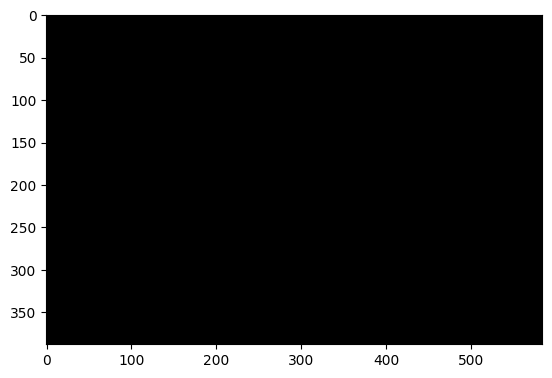

Execution time for bicubic interpolation skimage for 2 repetitions: 0.06550763199629728 sec
... in average: 0.03275381599814864 sec


In [17]:
# we try to replace our bicubic interpolation with the skimage implementation
tform = ski.transform.EuclideanTransform(translation=(p[0], p[1]))
transformed_image = ski.transform.warp(I1, tform, preserve_range=True)
DI = transformed_image - I1
print(" max DI = ", np.max(np.max(DI)))
plt.imshow(ski.exposure.rescale_intensity(DI))
plt.show()

def time_bicubic_interpolation_image_skimage():
    return ski.transform.warp(I1, tform, preserve_range=True)

nrepeats = 2
elapsed_time = timeit.timeit(stmt=time_bicubic_interpolation_image_skimage, number=nrepeats)
print("Execution time for bicubic interpolation skimage for {} repetitions: {} sec".format(nrepeats, elapsed_time))
print("... in average: {} sec".format(elapsed_time/nrepeats))